In [1]:
# insert at 1, 0 is the script path (or '' in REPL)
import numpy as np
import parla as rla
import scipy.linalg as la
from matplotlib import pyplot as plt

This notebook shows a procedural API for approximate low-rank symmetric eigendecomposition of real matrices. These implementations DO NOT check if the input matrix is actually symmetric. 

The first function, ``evd1``, works for any symmetric input. 
It's based on Algorithm 5.3 from

***Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp."Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions."***

The second function, ``evd2``, will only work properly with positive semidefinite inputs. It's based on the method proposed in 

***Joel A Tropp, Alp Yurtsever, Madeleine Udell, and Volkan Cevher."Fixed-rank approximation of a positive-semidefinite matrix from streaming data."Advances in neural information processing systems, 2017.***

Eigenvector discrepency for evd1:
	 3.706562175445525
Eigenvector discrepency for evd2:
	 2.8162819554900196


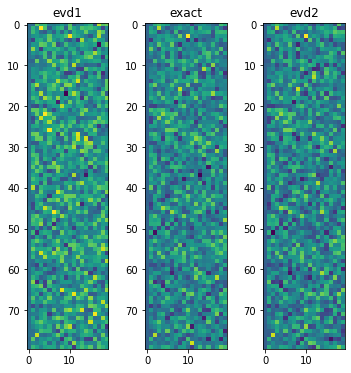

In [2]:
rng = np.random.default_rng(10000)

n = 80
exact_rank = 60  # must be  <= n.
A0 = rng.uniform(size=(exact_rank, n))
A0 = A0.T @ A0
target_rank = 20
over = target_rank // 2  # oversampling parameter

def are_cols_acute(u_, v_):
    assert u_.shape == v_.shape
    n_cols = u_.shape[1]
    signs = np.ones(n_cols)
    elem_prods = u_ * v_
    inner_prods = np.sum(elem_prods, axis=0)
    signs = np.sign(inner_prods)
    signs[signs > -1] = 1
    return signs

fig = plt.figure(figsize=(6,6))
axes = fig.subplots(nrows=1, ncols=3)

# Compute the exact eigendecomposition for reference
lamb0, V0 = la.eigh(A0)
lamb0 = lamb0[::-1]
V0 = V0[:, ::-1]  # reverse the order of columns, to sort in decreasing order of eigvals
V0 = V0[:, :target_rank]
axes[1].imshow(V0)
axes[1].set_title('exact')



# The evd1 method works for Hermitian matrices
#
#     It requires inner_num_pass >= 2.
#
#     It will perform up to
#       inner_num_pass * ceil((target_rank + over) / block_size)
#     passes over A.
#
V1,L1 = rla.drivers.evd.evd1(
             A=A0,
             k=target_rank,
             tol=0.0,
             over=over,
             inner_num_pass=2,
             block_size=4,
             rng=123)
V1 = V1 * are_cols_acute(V0, V1)
axes[0].imshow(V1)
axes[0].set_title('evd1')


# The evd1 method works for Hermitian positive semidefinite matrices
#
#     It requires num_passes >= 1.
#
#     It will only perform a total of num_passes over A.
#
V2,L2 = rla.drivers.evd.evd2(
             A=A0,
             k=target_rank,
             over=over,
             num_passes=2,
             rng=123)
V2 = V2 * are_cols_acute(V0, V2)
axes[2].imshow(V2)
axes[2].set_title('evd2')


print('Eigenvector discrepency for evd1:')
print('\t %s' % str(la.norm(V1 - V0)))
print('Eigenvector discrepency for evd2:')
print('\t %s' % str(la.norm(V2 - V0)))

# Note: we should add an option to enforce a sign convention for the returned eigenvectors.